In [1]:
import json
import os
import numpy
import pandas
import pyarrow
import sys

from datetime import date
from os import path
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Steps to install
# 1. pip install sqlalchemy-bigquery google-cloud-bigquery-storage pyarrow
# 2. Copy the credentials file to wherever you set BIGQUERY_CREDENTIALS_PATH to

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')

In [2]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
import create_queries
%load_ext autoreload
%autoreload 2

In [3]:
COMPANY_NAME = 'RA'
COMPANY_IDENTIFIER = 'RA'
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
INVENTORY_DATES = [
    '01/31/2020',
    '02/28/2020',
    '03/31/2020',
    '04/30/2020',
    '05/31/2020',
    '06/30/2020',
    '07/31/2020',
    '08/31/2020',
    '09/30/2020',
    '10/31/2020',
    '11/30/2020',
    '12/31/2020',
    '01/31/2021',
    '02/28/2021',
    '03/31/2021',
    '04/30/2021',
    '05/31/2021',
    '06/30/2021',
    '07/31/2021',
    '08/31/2021',
    '09/30/2021',
]
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0
}
TODAY_DATE = date.today().strftime('%m/%d/%Y')
INVENTORY_DATES.append(TODAY_DATE)
print('Today is {}'.format(TODAY_DATE))

Today is 10/28/2021


In [4]:
# Download packages, sales transactions, incoming / outgoing tranfers

company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(COMPANY_IDENTIFIER)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

company_incoming_transfer_packages_dataframe = pandas.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pandas.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_sales_transactions_dataframe = pandas.read_sql_query(company_sales_transactions_query, engine)
company_inventory_packages_dataframe = pandas.read_sql_query(company_inventory_packages_query, engine)

In [5]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts/analysis")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from util import active_inventory_util as util

In [6]:
d = util.Download()
d.download_dataframes(
    incoming_transfer_packages_dataframe=company_incoming_transfer_packages_dataframe,
    outgoing_transfer_packages_dataframe=company_outgoing_transfer_packages_dataframe,
    sales_transactions_dataframe=company_sales_transactions_dataframe,
)

In [7]:
# Check for how many packages are excluded from analysis,
# seeing less then 2% is really good
q = util.Query()
q.inventory_dates = INVENTORY_DATES
q.company_name = COMPANY_NAME

id_to_history = util.get_histories(d)
util.print_counts(id_to_history)
util.create_inventory_xlsx(id_to_history, q, params=ANALYSIS_PARAMS)

Only outgoing: 7
Only incoming: 1595
Only sold: 17
In and out: 37
In and sold at least once 4148
In and sold many times 4012
Total pkgs: 5781


/Users/warren/sweat-equity-ventures/bespoke/platform/services/api-server/scripts/analysis/util/active_inventory_util.py:154: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  if cur_date < arrived_date:


Wrote result to out/RA_inventory_by_month.xls
Excluded 53 / 5781 packages from consideration (0.92%)
  OUT_OF_ORDER_DATES: 29 times
  MISSING_INCOMING: 24 times


In [8]:
import math

import importlib
importlib.reload(util)

date_to_inventory_packages_dataframe = {}
id_to_history = util.get_histories(d)

inventory_valuations = []

for inventory_date in INVENTORY_DATES:
    computed_inventory_package_records = util.create_inventory_dataframe_by_date(
        id_to_history, inventory_date, params=ANALYSIS_PARAMS)    
    computed_inventory_packages_dataframe = pandas.DataFrame(
        computed_inventory_package_records,
        columns=[
            'package_id',
            'license_number',
            'arrived_date',
            'product_category_name',
            'product_name',
            'quantity',
            'sold_date',
            'is_in_inventory'
        ]
    )
    date_to_inventory_packages_dataframe[inventory_date] = computed_inventory_packages_dataframe
    in_inventory_computed_inventory_packages_dataframe = computed_inventory_packages_dataframe[computed_inventory_packages_dataframe['is_in_inventory'] == 'true']
    print(len(in_inventory_computed_inventory_packages_dataframe.index))
    
    inventory_with_incoming_transfer_packages_dataframe = in_inventory_computed_inventory_packages_dataframe \
        .astype({'package_id': 'int64'}) \
        .merge(
            company_incoming_transfer_packages_dataframe.astype({'package_id': 'int64'}),
            on='package_id',
            how='inner',
            suffixes=('_l', '_r')
        )
    #     print(f'# of packages in inventory with incoming package: {len(inventory_with_incoming_transfer_packages_dataframe.index)}')

    inventory_with_cost_records = inventory_with_incoming_transfer_packages_dataframe.to_dict('record')

    total_valuation_cost = 0

    for inventory_with_cost_record in inventory_with_cost_records:
        incoming_shipped_price = inventory_with_cost_record['shipper_wholesale_price']
        if math.isnan(incoming_shipped_price):
            incoming_shipped_price = 0
        incoming_shipped_quantity = inventory_with_cost_record['shipped_quantity']
        current_quantity = inventory_with_cost_record['quantity']
        total_valuation_cost += float(current_quantity) * (incoming_shipped_price / incoming_shipped_quantity)
    
    print(total_valuation_cost)
    print('')
    inventory_valuations += [total_valuation_cost]

0
0



/Users/warren/venvs/bespoke/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


46
2478.8496045197744

230
25827.89276419717

546
57450.98082941315

720
53243.7757484291

889
53071.83812988746

1048
69668.59659548785

1319
111217.69815247356

1537
146117.56030743103

1802
186346.3452114081

1815
141868.17218673235

1926
128358.62086632919

2138
137233.34504209933

2326
125398.47395152973

2444
125780.8721868799

2605
168007.1078969941

2794
175367.65237156907

2936
161499.03986173804

3112
160013.624766192

3249
162738.89938540262

3411
175072.7016424702

3537
168378.65754624218



In [9]:
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)

In [10]:
fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = company_sales_receipts_dataframe.apply(fn, axis=1)
company_sales_receipts_dataframe = company_sales_receipts_dataframe.assign(sales_month=col.values)

In [11]:
# company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)
gmv_by_month_dataframe = company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum()
gmv_by_month_dataframe

sales_month
2020-03     33886.44
2020-04     88659.34
2020-05    135380.48
2020-06    148263.48
2020-07    174943.68
2020-08    186034.10
2020-09    199931.81
2020-10    207834.38
2020-11    200319.70
2020-12    220334.99
2021-01    216208.37
2021-02    189439.27
2021-03    212136.22
2021-04    238124.90
2021-05    248644.73
2021-06    220601.48
2021-07    219837.94
2021-08    214533.51
2021-09    180901.27
2021-10    157627.51
Name: total_price, dtype: float64

In [12]:
list(gmv_by_month_dataframe.array)

[33886.439999999966,
 88659.33999999978,
 135380.48,
 148263.47999999986,
 174943.6799999999,
 186034.10000000027,
 199931.81,
 207834.3800000001,
 200319.69999999978,
 220334.98999999976,
 216208.37,
 189439.27000000022,
 212136.21999999997,
 238124.90000000005,
 248644.7299999998,
 220601.4799999999,
 219837.94000000015,
 214533.50999999992,
 180901.26999999958,
 157627.50999999983]

In [15]:
len(INVENTORY_DATES), len(inventory_valuations), len([None, None] + list(gmv_by_month_dataframe.array))

(22, 22, 22)

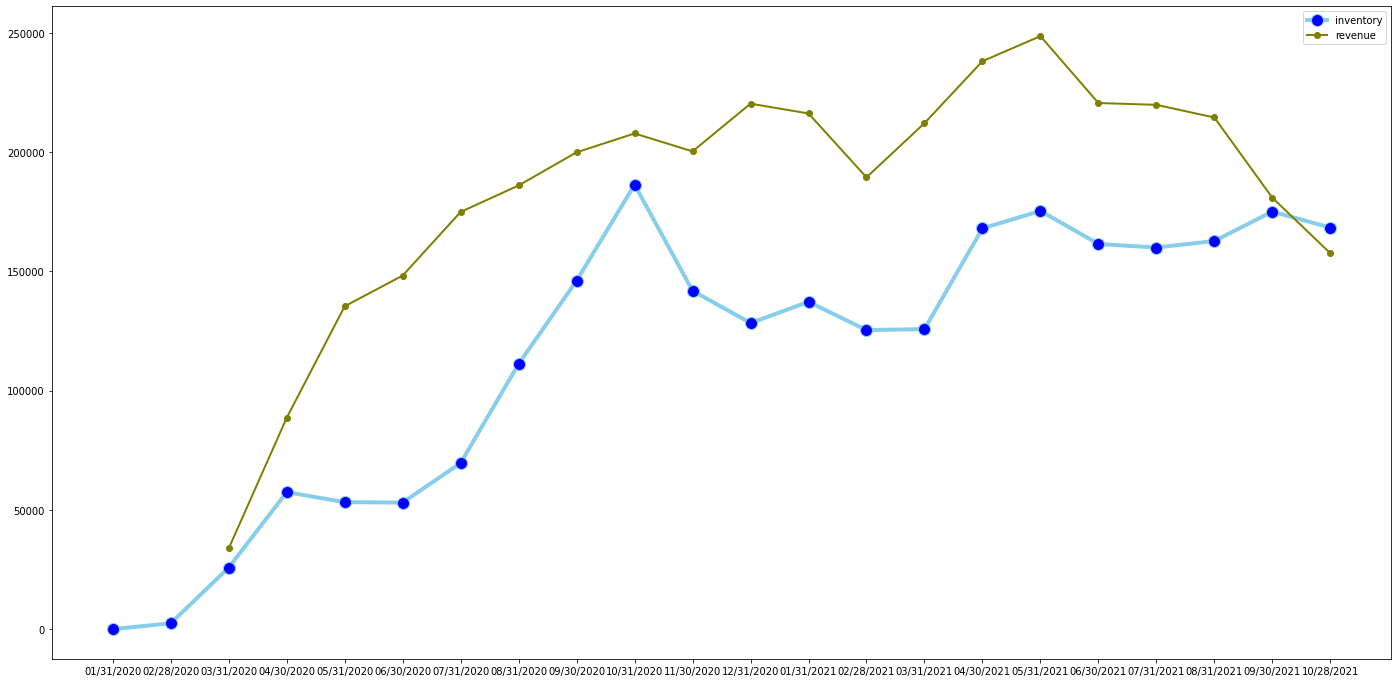

In [16]:
import matplotlib.pyplot as plt

df = pandas.DataFrame({
    'x_values': INVENTORY_DATES,
    'inventory': inventory_valuations,
    'revenue': [None, None] + list(gmv_by_month_dataframe.array),
})
 
# multiple line plots
plt.figure(figsize=(24, 12))
plt.plot( 'x_values', 'inventory', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x_values', 'revenue', data=df, marker='o', color='olive', linewidth=2)

# show legend
plt.legend()

# show graph
plt.show()